## Imports

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import textstat
from collections import Counter # 품사 태그 계산 Counter
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize

## Data

In [4]:
data = pd.read_excel("combined_data_NLP.xlsx")
data = data.rename({"question":"Question", "attempt":"Attempt", "answer":"Answer"}, axis = 1)

## 기초 통계량 계산

In [ ]:
def count_unique_words(text):
    """텍스트 내 고유 단어 수 계산 (간단 전처리 포함)"""
    if not isinstance(text, str): return 0
    words = re.sub(r'[^a-z0-9\s]', '', str(text).lower()).split()
    return len(set(w for w in words if w))

def cal_LD(text):
    tokens = word_tokenize(text.lower())
    tagged = pos_tag(tokens)

    content_tags = {'NN','NNS','NNP','NNPS', ## Nouns
                    'VB','VBD','VBG','VBN','VBP','VBZ', ## Verbs
                    'JJ','JJR','JJS', ## Adjectives
                    'RB','RBR','RBS'} ## Adverbs
    content_words = [word for word, tag in tagged if tag in content_tags]

    if len(tokens) == 0:
        return 0
    return len(content_words) / len(tokens)

def cal_prp(text):
    tokens = word_tokenize(text.lower())
    tagged = pos_tag(tokens)

    pronouns = [word for word, tag in tagged if tag == "PRP"]

    if len(tokens) == 0:
        return 0
    return len(pronouns) / len(tokens)

In [ ]:
data['Answer_clean'] = data['Answer'].fillna('')
data['char_count'] = data['Answer_clean'].str.len()
data['word_count'] = data['Answer_clean'].apply(lambda x: len(x.split()))
data['sentence_count'] = data['Answer_clean'].apply(lambda x: len(re.findall(r'[.!?]+', x)) + 1 if x.strip() else 0)
data['unique_word_count'] = data['Answer_clean'].apply(count_unique_words)
data["grade_level"] = data["Answer"].apply(textstat.flesch_kincaid_grade)

In [ ]:
data['avg_sentence_length'] = np.where(data['sentence_count'] > 0, data['word_count'] / data['sentence_count'], 0)
data['avg_word_length'] = np.where(data['word_count'] > 0, data['char_count'] / data['word_count'], 0)

data["lexical_density"] = data["Answer"].apply(cal_LD)
data["personal_pronoun_proportion"] = data["Answer"].apply(cal_prp)

In [14]:
metrics_to_analyze = [
    'char_count', 'word_count', 'sentence_count', 'avg_sentence_length', "avg_word_length",
    'unique_word_count', 'personal_pronoun_proportion', 'lexical_density', 'grade_level'
]

In [ ]:
df = data

if 'model' in df.columns:
    df['model'] = df['model'].astype(str)
    stats_by_model = df.groupby('model')[metrics_to_analyze].agg(['max', 'mean', 'median', 'std', 'min'])

In [17]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(stats_by_model)

         char_count                                        word_count  \
                max         mean  median          std  min        max   
model                                                                   
claude         1591  1026.855000  1024.0   156.135772  393        257   
deepseek       3451  1090.596000  1011.0   382.002836  431        536   
gemini         2619  1223.316667  1180.0   318.946326  411        486   
gpt            3107  1621.918667  1589.0   353.029028  696        502   
human         13363  1433.840099  1008.0  1442.480328   87       2329   

                                             sentence_count                    \
                mean median         std  min            max       mean median   
model                                                                           
claude    172.824667  172.0   23.802047   68             28  11.969000   12.0   
deepseek  177.799333  166.0   57.350194   72             50  13.373333   12.0   
gemini    

## 시각화

In [ ]:
metrics_to_analyze = [
    'char_count', 'word_count', 'sentence_count', 'avg_sentence_length', "avg_word_length",
    'unique_word_count', 'personal_pronoun_proportion', 'lexical_density', 'grade_level'
]

In [20]:
exact_metrics = [
    "Character Count", "Word Count", "Sentence Count", "Average Sentence Length", "Average Word Length",
    "Unique Word Count", "Personal Pronoun Proportion", "Lexical Density", "Flesch-Kincaid Grade Level"
]

/tmp/ipykernel_1515033/1187786788.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='model', y=metric, ax=axes_box[i], palette=palette, showfliers=False, order=unique_models)
/tmp/ipykernel_1515033/1187786788.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='model', y=metric, ax=axes_box[i], palette=palette, showfliers=False, order=unique_models)
/tmp/ipykernel_1515033/1187786788.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='model', y=metric, ax=axes_box[i], palette=palette, showfliers=False, o

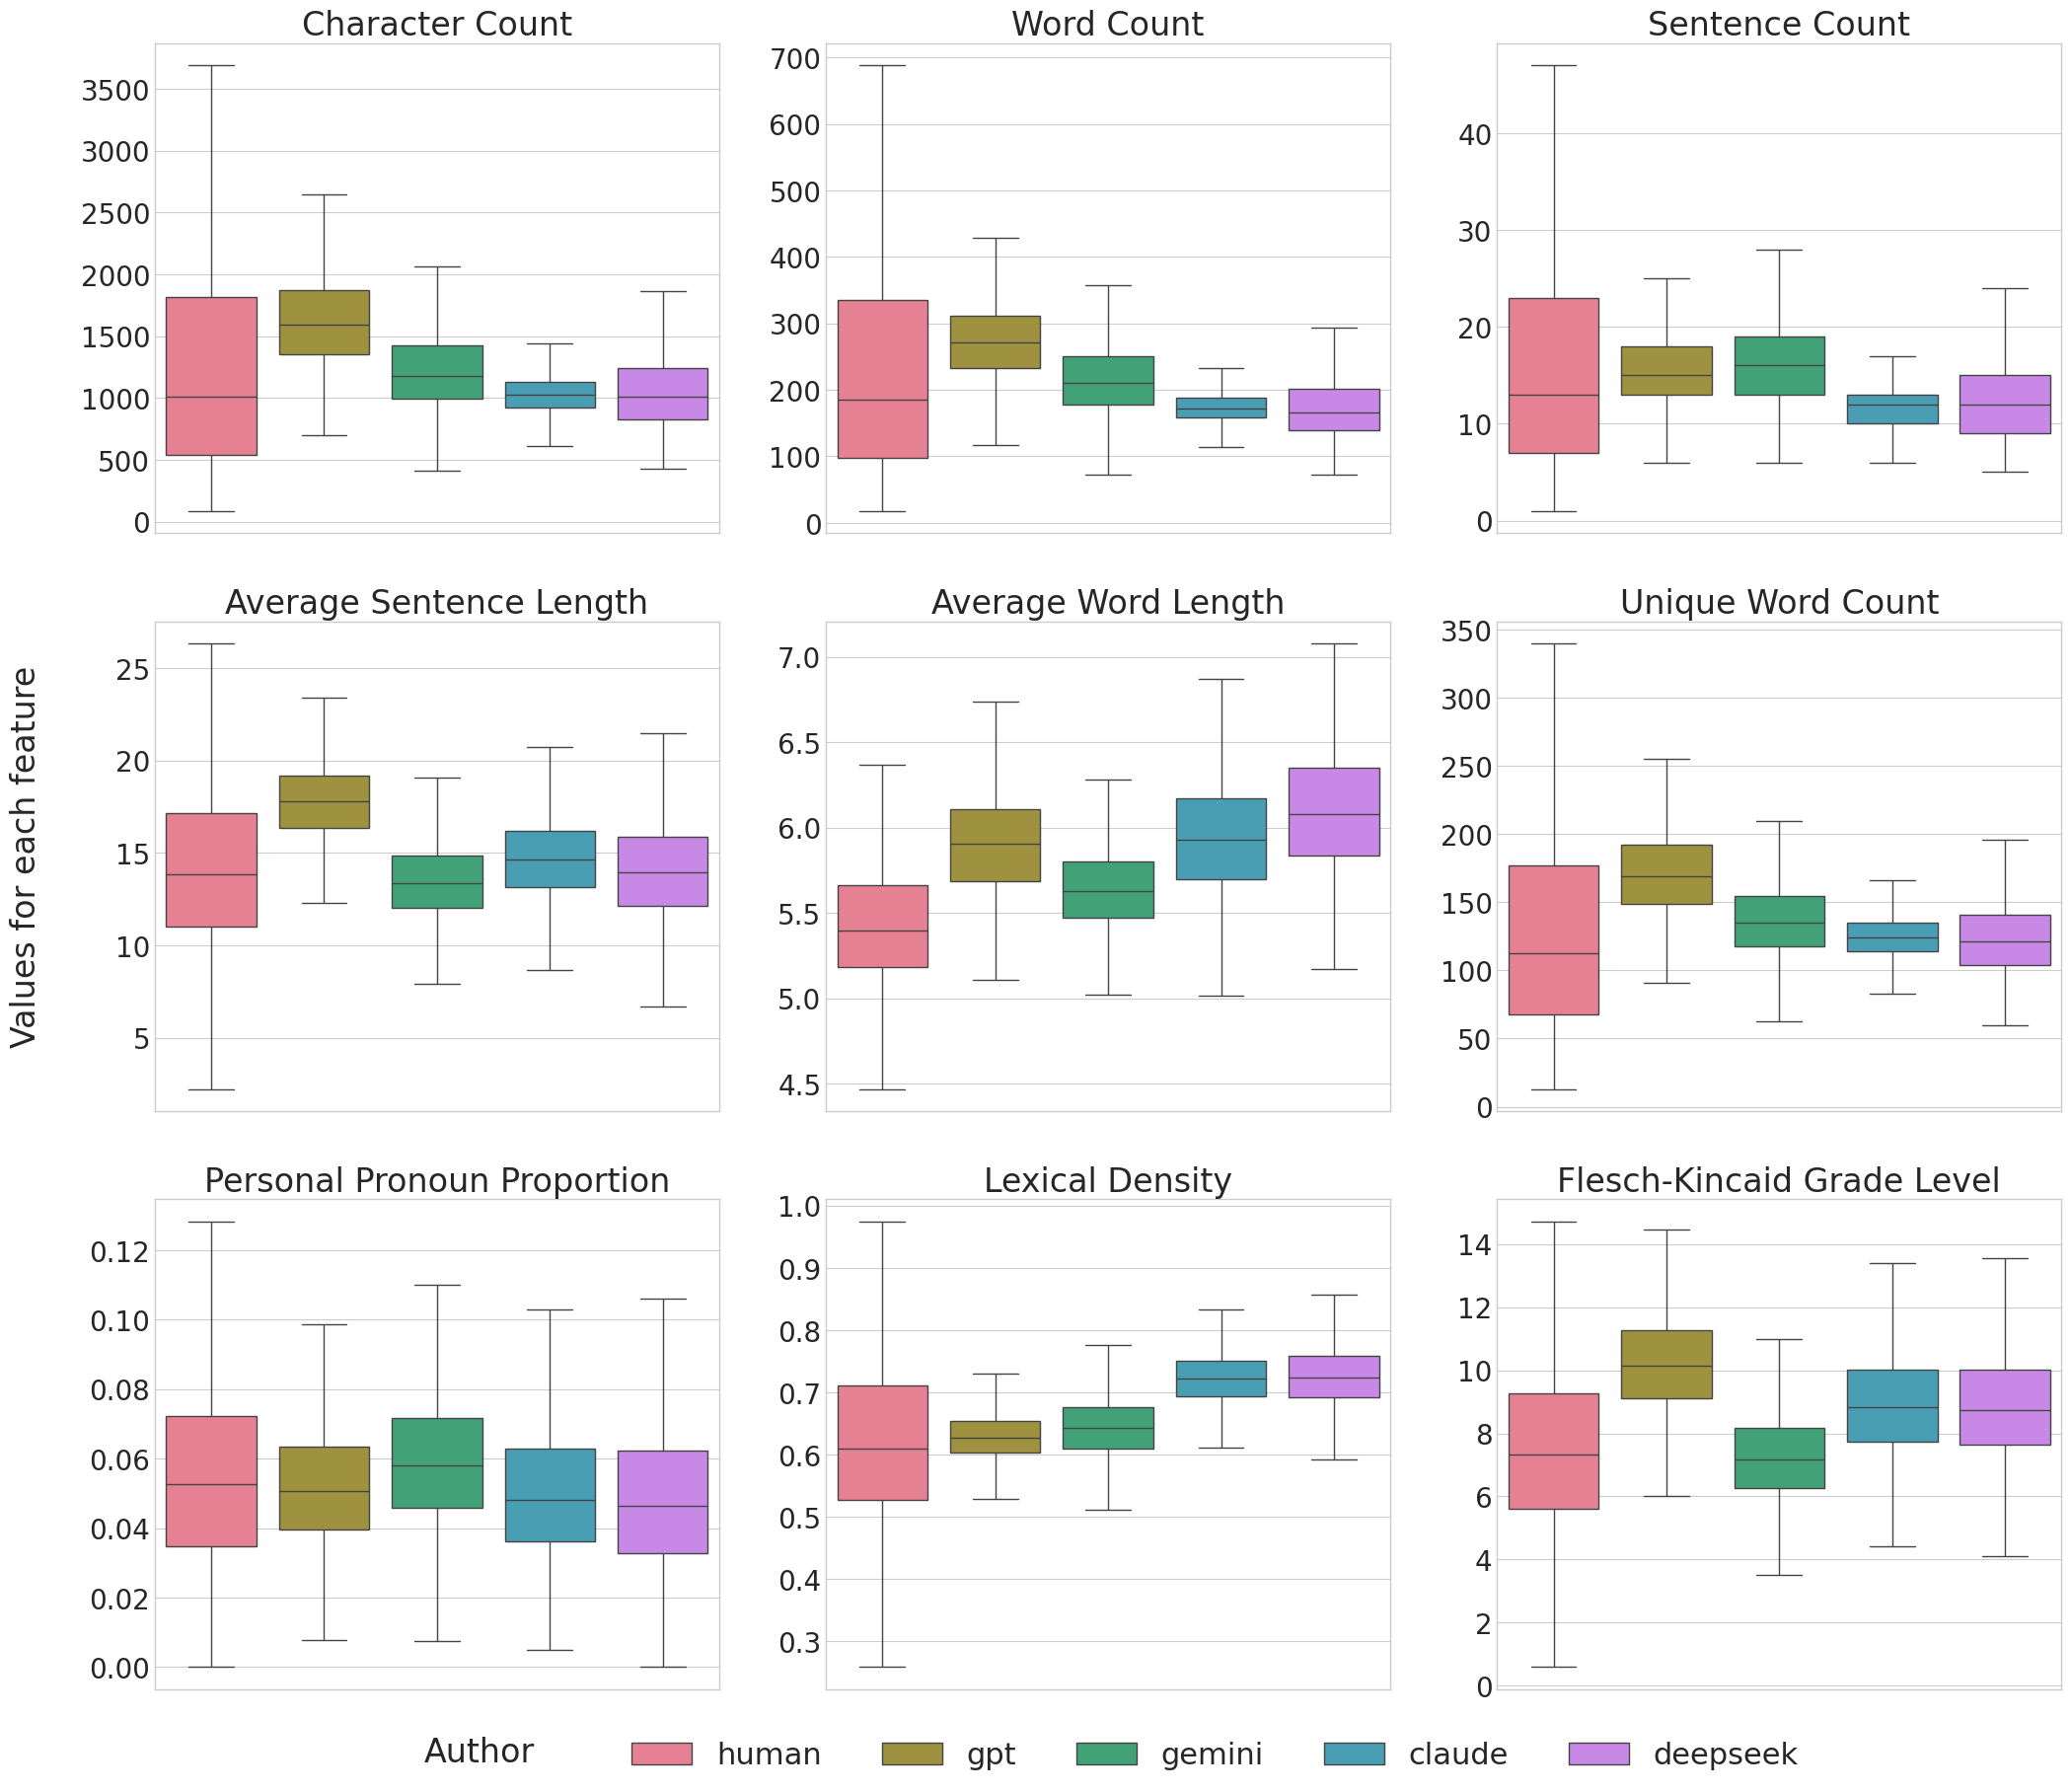

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
unique_models = ["human", "gpt", "gemini", "claude", "deepseek"] ## 논문에서의 레이블링 순서대로 정렬
palette = sns.color_palette("husl", len(unique_models))

n_metrics = len(metrics_to_analyze)
n_cols = 3
n_rows = (n_metrics + n_cols - 1) // n_cols
fig_box, axes_box = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 6 * n_rows))
axes_box = axes_box.flatten()

for i, (metric, name) in enumerate(zip(metrics_to_analyze, exact_metrics)):
    sns.boxplot(data=df, x='model', y=metric, ax=axes_box[i], palette=palette, showfliers=False, order=unique_models)
    # axes_box[i].set_title(f'{metric} Distribution', fontsize=14)
    axes_box[i].set_title(name, fontsize = 24)
    # axes_box[i].set_xlabel('Model', fontsize=12)
    axes_box[i].set_xlabel('', fontsize=22)
    # axes_box[i].set_ylabel(metric.replace('_', ' ').title(), fontsize=12)
    axes_box[i].set_ylabel('', fontsize=22)
    axes_box[i].set_xticklabels("")
    axes_box[i].tick_params(axis='x', labelsize=20)
    axes_box[i].tick_params(axis='y', labelsize=20)

for j in range(i + 1, len(axes_box)): fig_box.delaxes(axes_box[j])

fig_box.text(0.19, -0.01, "Author", fontsize = 24)
fig_box.text(-0.01, 0.5, 'Values for each feature', va = "center", rotation = "vertical", fontsize = 24)

plt.tight_layout(pad = 3.0)
plt.legend(unique_models, bbox_to_anchor=(-0.5,-0.22), loc='lower center', ncol = 5, fontsize = 22)
plt.savefig("feature_box_tidy_en.png", dpi=300, bbox_inches = "tight")

/tmp/ipykernel_1515033/1187786788.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='model', y=metric, ax=axes_box[i], palette=palette, showfliers=False, order=unique_models)
/tmp/ipykernel_1515033/1187786788.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='model', y=metric, ax=axes_box[i], palette=palette, showfliers=False, order=unique_models)
/tmp/ipykernel_1515033/1187786788.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='model', y=metric, ax=axes_box[i], palette=palette, showfliers=False, o

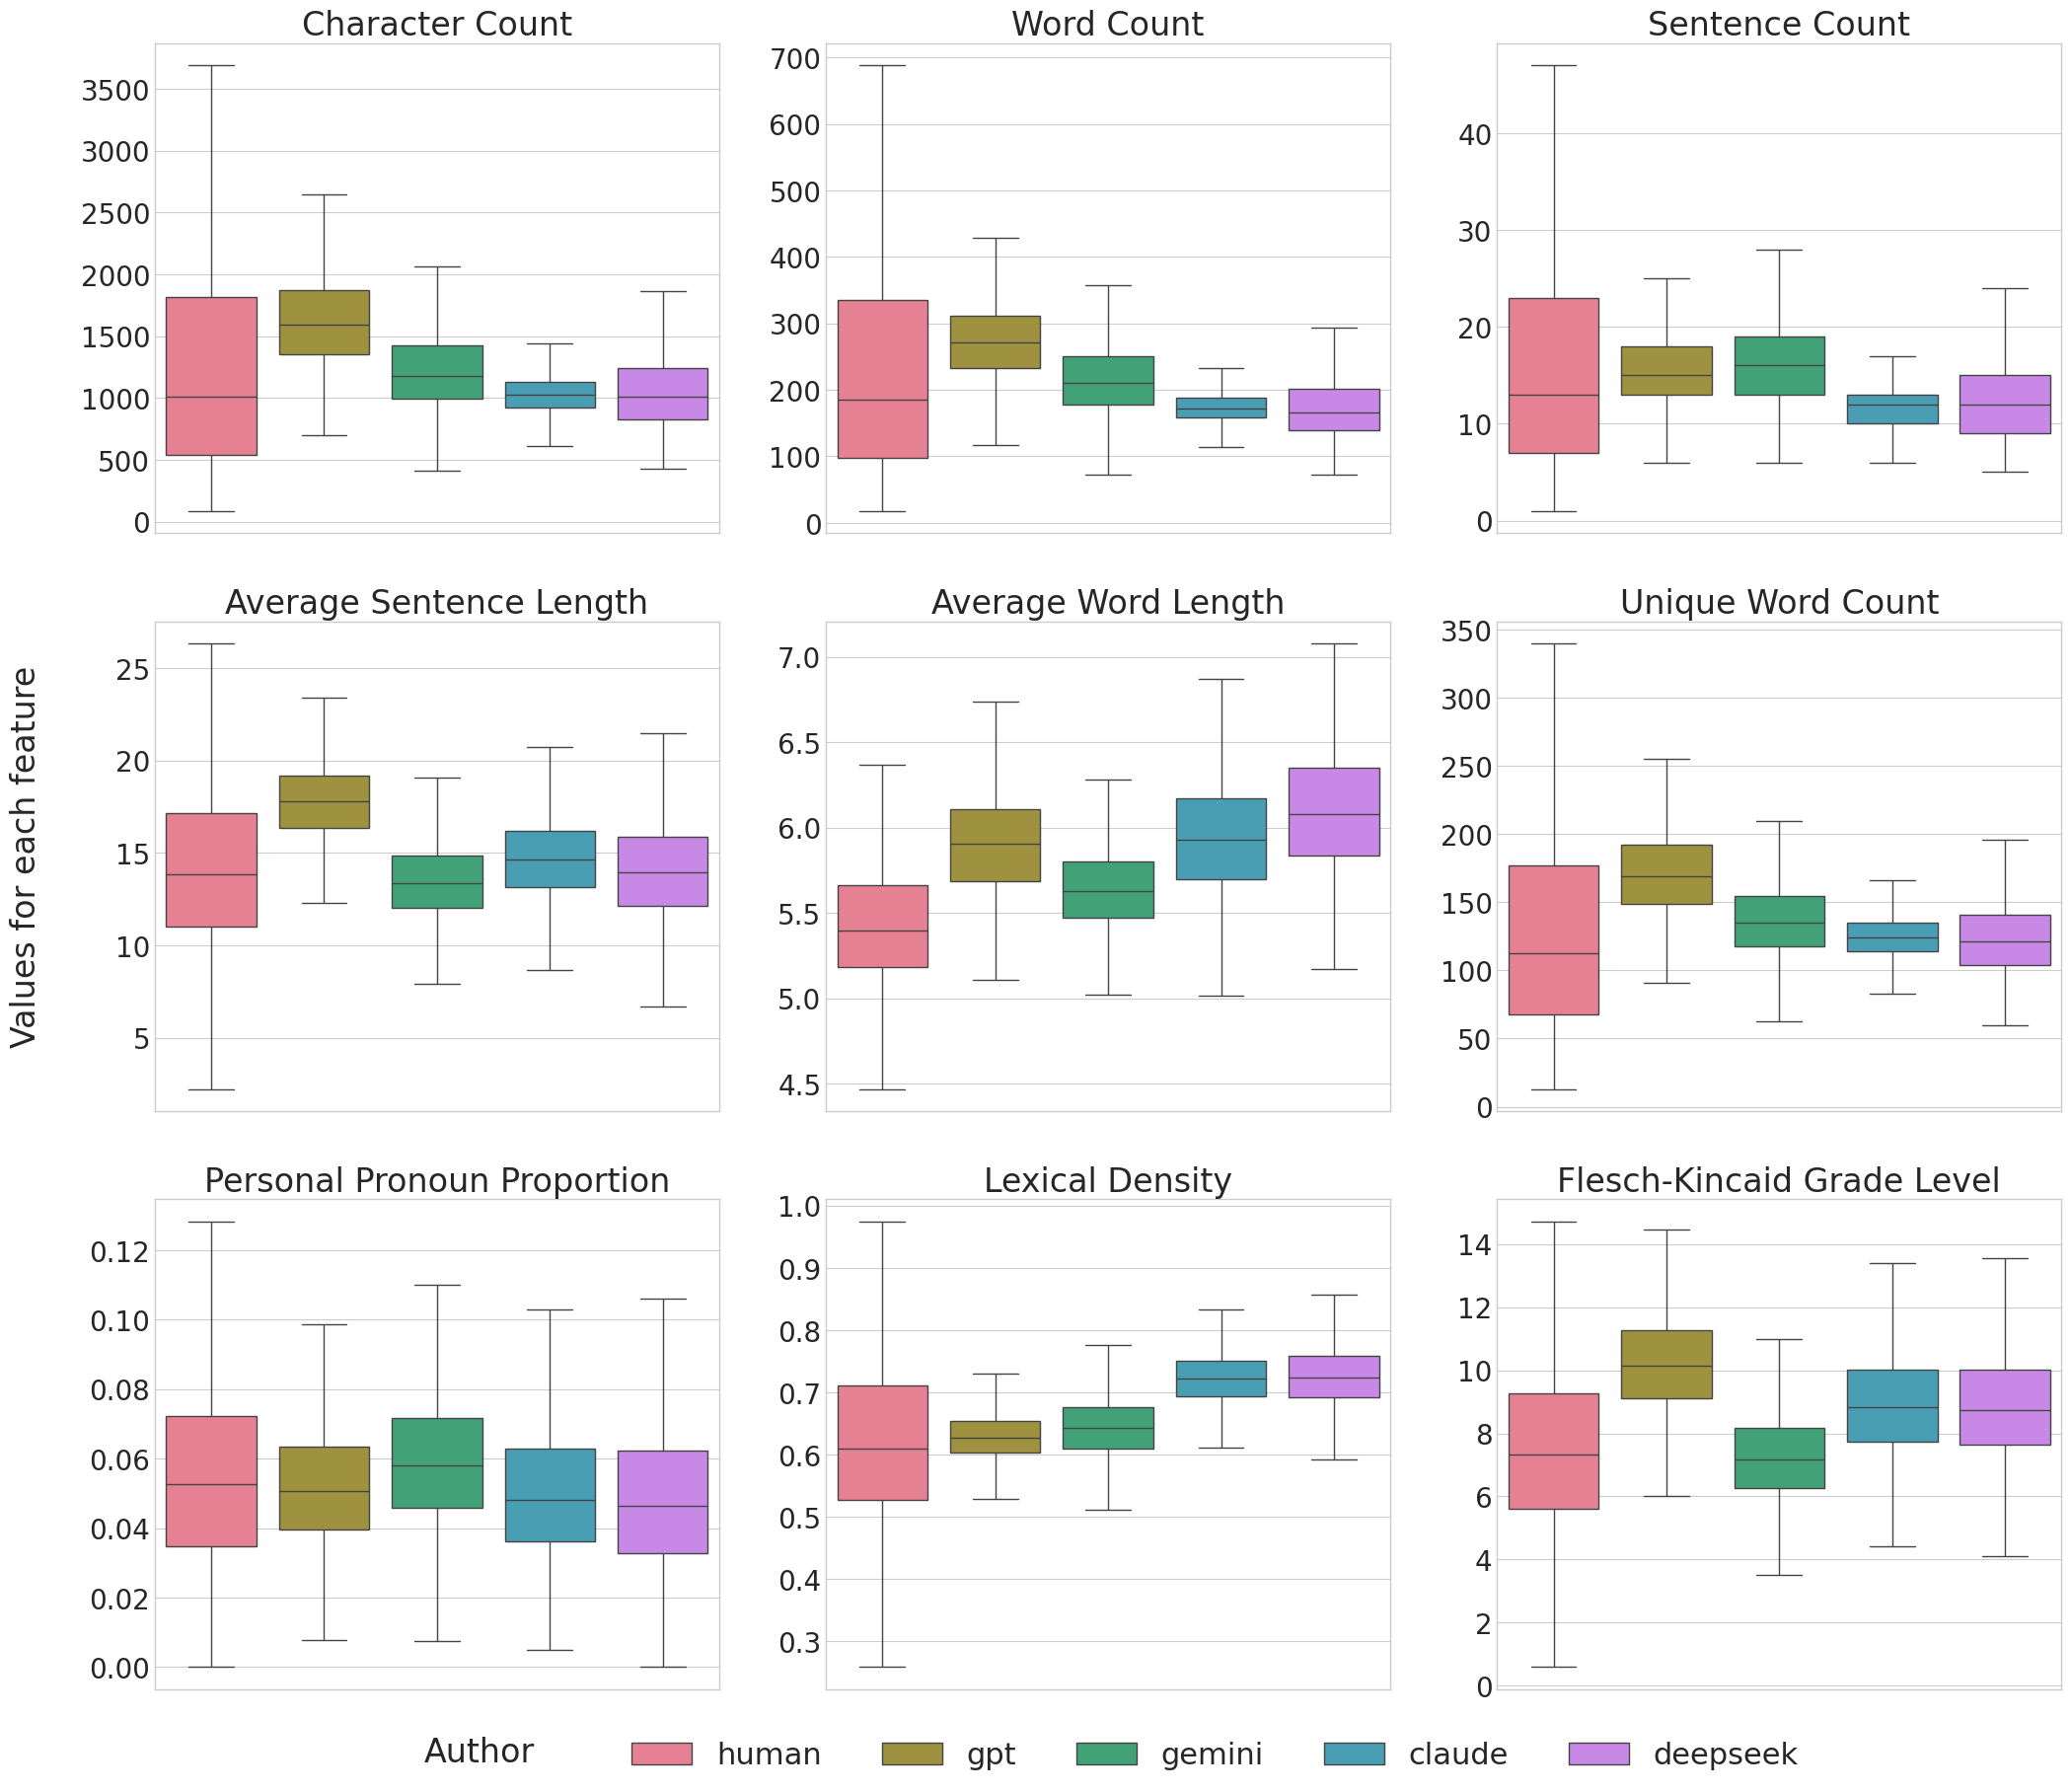

In [ ]:
## boxplot.png
plt.style.use('seaborn-v0_8-whitegrid')
unique_models = ["human", "gpt", "gemini", "claude", "deepseek"] ## 논문에서의 순서대로 정렬
palette = sns.color_palette("husl", len(unique_models))

n_metrics = len(metrics_to_analyze)
n_cols = 3
n_rows = (n_metrics + n_cols - 1) // n_cols
fig_box, axes_box = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 6 * n_rows))
axes_box = axes_box.flatten()

for i, (metric, name) in enumerate(zip(metrics_to_analyze, exact_metrics)):
    sns.boxplot(data=df, x='model', y=metric, ax=axes_box[i], palette=palette, showfliers=False, order=unique_models)
    # axes_box[i].set_title(f'{metric} Distribution', fontsize=14)
    axes_box[i].set_title(name, fontsize = 24)
    # axes_box[i].set_xlabel('Model', fontsize=12)
    axes_box[i].set_xlabel('', fontsize=22)
    # axes_box[i].set_ylabel(metric.replace('_', ' ').title(), fontsize=12)
    axes_box[i].set_ylabel('', fontsize=22)
    axes_box[i].set_xticklabels("")
    axes_box[i].tick_params(axis='x', labelsize=20)
    axes_box[i].tick_params(axis='y', labelsize=20)

for j in range(i + 1, len(axes_box)): fig_box.delaxes(axes_box[j])

fig_box.text(0.19, -0.01, "Author", fontsize = 24)
fig_box.text(-0.01, 0.5, 'Values for each feature', va = "center", rotation = "vertical", fontsize = 24)

plt.tight_layout(pad = 3.0)
plt.legend(unique_models, bbox_to_anchor=(-0.5,-0.22), loc='lower center', ncol = 5, fontsize = 22)
plt.savefig("feature_box_tidy_en.png", dpi=300, bbox_inches = "tight")